## Load packages

In [1]:
# Import required packages
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import time
import sys
import json
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
from PIL import Image


In [2]:
# Use the following command to install additional packages
!pip install tensorflow
!pip install nbresuse


Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
# Load additionaly installed packages
import tensorflow as tf
from joblib import load
from sklearn.svm import SVC


## Load data

In [4]:
# Create file path to the data
val_dir = './data/ValidationData'

# Create lists containing all image paths
val_normal = [os.path.join(val_dir, 'bad/{}').format(i) for i in os.listdir(os.path.join(val_dir, 'bad'))]
val_fluten = [os.path.join(val_dir, 'good/{}').format(i) for i in os.listdir(os.path.join(val_dir, 'good'))]
val_images = val_normal + val_fluten
np.random.shuffle(val_images)

In [5]:
# Warning: Due to the limited memory size, not all images can be loaded at once.
# We select only 100 images
val_images = val_images[0:100]

In [6]:
# Create empty list which will hold the images
X = []

# Create empty list which will hold the labels
y_true = []

# Loop over all image paths to read each image and their corresponding true label
for image in val_images:
    # Ignore .ipynb-checkpoint files
    if 'ipynb' in image:
        continue
        
    # Read the image
    X.append(cv2.imread(image,1))
    
    # Load the true label
    if 'fluten' in image:
        y_true.append(1)
    elif 'normal' in image:
        y_true.append(0)

## Preprocessing

In [7]:
# Add your Preprocessing here

# Functions
def normalize_imgs(imgs):
    """
    Normalizing image data
    :param imgs: Raw Image data
    :return:  Normalized image data
    """


    imgs = (imgs - np.min(np.min(imgs, axis=2), axis=1)[:, np.newaxis, np.newaxis]) / (np.max(np.max(imgs, axis=2),
                                                                                              axis=1) - np.min(
        np.min(imgs, axis=2), axis=1))[:, np.newaxis, np.newaxis]
    return imgs


def extract_features(image_data):
    """
    Extracting features from normalized image data.
    :param image_data: Normalized image data
    :return: Features for the SVM
    """

    # Max/Min Pooling for undersampling image data
    pooling = tf.keras.layers.MaxPool2D(pool_size=(50, 50), strides=50, padding='valid')

    # Feature 1: Local Contrast Average
    tf_image_data = tf.convert_to_tensor(image_data[:, 200:500, 200:1000])
    max = pooling(tf.expand_dims(tf_image_data, axis=-1))
    min = -pooling(tf.expand_dims(-tf_image_data, axis=-1))
    dif = max - min

    f1 = tf.math.reduce_mean(dif, axis=[1, 2])
    f1 = f1.numpy()

    del max, min, tf_image_data, dif

    # Feature 2: Bottom Contrast
    tf_image_data = tf.convert_to_tensor(image_data[:, 1400:1750, 200:1000])

    max = pooling(tf.expand_dims(tf_image_data, axis=-1))
    min = -pooling(tf.expand_dims(-tf_image_data, axis=-1))
    dif = max - min

    f2 = tf.math.reduce_mean(dif, axis=[1, 2])
    f2 = f2.numpy()

    del max, min, tf_image_data, dif

    return f1, f2


# resizing image data to uniform size and turn it into greyscale
X = [cv2.resize(cv2.cvtColor(el, cv2.COLOR_BGR2GRAY), (1200, 1850)) for el in X]

# convert image data to Numpy arrays
X = np.asarray(X)

y_true = np.asarray(y_true)

# batchwise feature extraction
X = np.array_split(X, 5)

f1 = np.empty(0)
f2 = np.empty(0)

for batch in X:
    # Normalize Images
    batch = normalize_imgs(batch)
    # Extract Features
    _, __ = extract_features(batch)
    f1 = np.append(f1, _)
    f2 = np.append(f2, __)

X = np.concatenate((f1[:, np.newaxis], f2[:, np.newaxis]), axis=1)

## Load model

In [8]:
# Load your trained model here
clf = load("./svm_final")

## Predicitions

In [9]:
# Start the timer to measure the computation time needed for inference (please do not modify the following line)
start_time = time.time()

# Use your loaded model to make a prediction of the label of each image
y_pred_probs = clf.predict_proba(X)[:,1]

# End timer (please do not modify the following line)
comp_time = round((time.time() - start_time),3)
print("--- %s seconds ---" % comp_time)

# Transform probabilities to labels
# Since we are using a SVM y_pred = clf.predict(X) would be more accurate
# but a treshold based model was required

y_pred = np.where(y_pred_probs>= 0.5,1,0)

--- 0.05 seconds ---


## Evaluation

### The following lines should not be modified

In [10]:
# Compute the confusion matrix
cfmtx = pd.DataFrame(
    confusion_matrix(y_true, y_pred), 
    index=['True: Fluten', 'True: Normal'], 
    columns=['Pred: Fluten', 'Pred: Normal']
)
print(cfmtx)

              Pred: Fluten  Pred: Normal
True: Fluten            56             0
True: Normal             0            44


In [11]:
# Compute the error rate
accuracy = accuracy_score(y_true, y_pred)
print('Error rate= %.3f' % (1-accuracy))

Error rate= 0.000


In [12]:
# Compute the ROC AUC
roc_auc = roc_auc_score(y_true, y_pred_probs)
print('ROC AUC = %.3f' % (roc_auc))

ROC AUC = 1.000


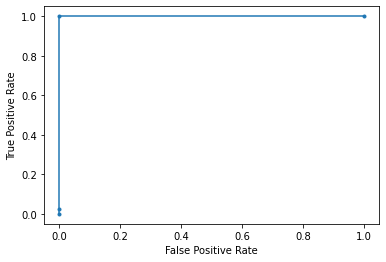

In [13]:
# Calculate ROC curve
lr_fpr, lr_tpr, _ = roc_curve(y_true, y_pred_probs)
# Plot the ROC curve for the model
plt.plot(lr_fpr, lr_tpr, marker='.')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show the plot
plt.show()

## Save results

In [14]:
# results = pd.DataFrame({'Image':val_images,'Label':y_pred})

In [15]:
res_dict = {}
res_dict['ER'] = 1-round(accuracy,3)
res_dict['ROC'] = roc_auc
res_dict['FP'] = int(cfmtx['Pred: Fluten'].iloc[1])
res_dict['FN'] = int(cfmtx['Pred: Normal'].iloc[0])
res_dict['TIME'] = int(comp_time)

with open('results_metrics.json', 'w') as fp:
    json.dump(res_dict, fp)